# Notebook
Notebook for prototyping and experimenting. 

### New Simulation Config


In [ ]:

# beam_settings = load_beam_config(config["beam"])

# lenses = [load_lens_config(lc) for lc in config["lenses"]]
# stages = [load_sim_stage_config(sc) for sc in config["stages"]]

# options = generate_simulation_options(config, "log")
# parameters = generate_simulation_parameters(config)


# sim_config = SimulationConfig(
#     beam=beam_settings,
#     lenses=lenses,
#     stages=stages,
#     parameters=parameters,
#     options=options
# )


# print("SIM CONFIG:")
# pprint(sim_config.beam)
# print("-"*50)
# pprint(sim_config.lenses)
# print("-"*50)
# pprint(sim_config.stages)
# print("-"*50)
# pprint(sim_config.parameters)
# print("-"*50)
# pprint(sim_config.options)



## Electric Field Refactor
Restructure the simulation to use electric field propagation rather than lenses



In [ ]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils, plotting
from lens_simulation.beam import generate_beam
from lens_simulation.Simulation import (generate_beam_simulation_stage, generate_simulation_parameters, 
    generate_sq_freq_arr, propagate_over_distance)
from lens_simulation import Simulation
from pprint import pprint
from lens_simulation.Lens import Lens
from scipy import fftpack
from lens_simulation.structures import SimulationStage, SimulationParameters, SimulationOptions, SimulationResult
from tqdm import tqdm
import numpy as np
import zarr
import matplotlib.pyplot as plt

path = "test"
config = utils.load_config("example/sim_charizard_2d.yaml")
config["log_dir"] = "log"

sim = Simulation.Simulation(config)
sim.run_simulation()

plotting.save_propagation_gif_full(sim.options.log_dir)


In [ ]:
from IPython.display import Image

plt.close()
fig = plotting.plot_sim_propagation_v2(sim.options.log_dir)
plt.show()

arr = plotting.load_full_sim_propagation_v2(sim.options.log_dir)
fig = plt.figure(figsize=(15, 15))
plt.imshow(np.flip(arr[-4,:, :]), aspect="auto", cmap="turbo")
plt.show()

Image(os.path.join(sim.options.log_dir, "propagation.gif"))



In [ ]:
from lens_simulation.beam import create_gaussian

path = "test"
config = utils.load_config("example/sim_gaussian_2d.yaml")
config["log_dir"] = path

parameters = generate_simulation_parameters(config)
beam_stage = generate_beam_simulation_stage(config, parameters)

z0 = 400.e-3
r0 = (0, 0)
w0 = 40.e-3

# parameters.sim_wavelength = 30e-3
arr = create_gaussian(r0, w0, z0, parameters=parameters, theta=0, phi=0)

print(parameters)

plt.imshow(np.abs(arr), cmap="turbo", aspect="auto")
plt.title("Gaussian")
plt.colorbar()
plt.show()

np.save("custom/gaussian.npy", arr)

fname = config["beam"]["data"]
loaded = utils.load_np_arr(fname)

plt.imshow(np.abs(loaded), cmap="turbo", aspect="auto")
plt.title("Gaussian (Loaded")
plt.colorbar()
plt.show()


In [ ]:
from PIL import Image
# star https://www.freeiconspng.com/images/white-star-icon
#fair use charizard https://en.wikipedia.org/wiki/Charizard#/media/File:Pok%C3%A9mon_Charizard_art.png
img = Image.open("custom/charizard.png")
img = img.resize((501, 501)).convert("L")
arr = np.asarray(img)
arr = arr>0 * 10000

arr = np.pad(arr, (1000, 1000), mode="constant", constant_values=0)

print(arr.shape)
plt.imshow(arr)
plt.show()

np.save("custom/charizard.npy", arr)

fname = config["beam"]["data"]
loaded = utils.load_np_arr("custom/charizard.npy")

plt.imshow(np.abs(loaded), cmap="turbo", aspect="auto")
plt.title("Charizard (Loaded")
plt.colorbar()
plt.show()

from scipy import fftpack
fft_charizard = fftpack.fft2(arr)

plt.imshow(abs(fft_charizard)**2, cmap="turbo")
plt.show()

np.save("custom/fft_charizard.npy", fft_charizard)


### Vectorisation Upgrade
Convert the propagate wavefront function use vectorised dask calculation. Measure performance

In [100]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils, plotting
from lens_simulation.Medium import Medium
from lens_simulation.Simulation import Simulation, calculate_stage_phase, calculate_wavefront_v2, generate_sq_freq_arr, propagate_wavefront_v2
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

import os

# vector version

# TODO: dask
# notes: slightly faster ... :(




def run_sim_test(vector):
    config = utils.load_config("example/sim_focus_2d.yaml")
    config["log_dir"] = "test"

    sim = Simulation(config)
    options = sim.options
    parameters = sim.parameters

    for stage in sim.sim_stages:

        if stage.wavefront is not None:
            propagation = stage.wavefront

        previous_wavefront = propagation

        # calculate stage phase profile
        phase = calculate_stage_phase(stage, parameters)

        # electric field (wavefront)
        amplitude: float = parameters.A if stage._id == 0 else 1.0
        wavefront = calculate_wavefront_v2(
            phase=phase,
            previous_wavefront=previous_wavefront,
            A=amplitude,
            aperture=stage.lens.aperture,
        )

        ## propagate wavefront
        if vector:
            result = propagate_wavefront_v3(wavefront=wavefront, 
                                stage=stage, 
                                parameters=parameters, 
                                options=options)
        else:
            result = propagate_wavefront_v2(wavefront=wavefront, 
                    stage=stage, 
                    parameters=parameters, 
                    options=options)
        
        propagation = result.propagation

    utils.save_metadata(config, options.log_dir)





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


22.3 s ± 794 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


21.8 s ± 407 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
from lens_simulation import utils, plotting
import napari
import numpy as np
path = r"C:\Users\pcle0002\Documents\repos\lens_simulation\log\duly-humble-sponge/saving-shiner"
# path = r"C:\Users\pcle0002\Documents\repos\lens_simulation\log\gently-stable-flea\intent-ibex"
sim = plotting.load_full_sim_propagation_v3(path)


viewer = napari.Viewer(ndisplay=3)
# mask = sim > 1e8
viewer.add_image(sim, name="simulation", scale=[1, 0.1, 0.1] ,rendering="mip", depiction="volume", interpolation="nearest", colormap="turbo")
# viewer.add_image(np.log(sim +1e-12), name="log_simulation", scale=[1, 0.1, 0.1] ,rendering="mip", depiction="volume", interpolation="nearest", colormap="turbo")

c:\Users\pcle0002\Miniconda3\envs\lens_sim\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'simulation' at 0x226c3168ac0>

NameError: name 'plt' is not defined

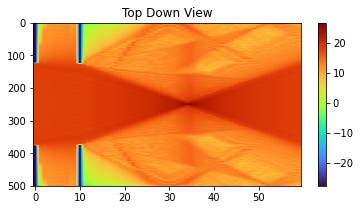

In [3]:
fig = plotting.plot_sim_propagation_v2(path, log=True)
plt.show()

0.0 88.44


c:\Users\pcle0002\Miniconda3\envs\lens_sim\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


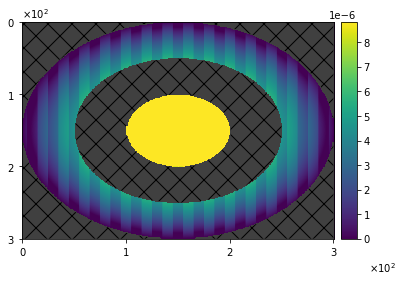

In [5]:



config = utils.load_config("config.yaml")

from lens_simulation.Lens  import generate_lens
from lens_simulation.Medium import Medium

lens = generate_lens(config["lenses"][0],  Medium(2.348), 1e-6)

plotting.plot_lens_profile_2D(lens)
# plt.show()
arr3d = plotting.create_3d_lens(lens)

plotting.view_lens3d_in_napari(arr3d)